# Loading simulated bandpowers

In [1]:
using HDF5
bandpowers = h5read("../bandpowers.h5", "bandpowers")

# beam and spectral density are set to somewhat resemble WMAP
const σ² = (10.0/3437.75)^2    # <---10μkarcmin noise level converted to radian pixels (1 radian = 3437.75 arcmin)
const b² = (0.0035)^2          # <-- pixel width 0.2ᵒ ≈ 12.0 armin ≈ 0.0035 radians

ell  = 0:length(bandpowers)-1
clεε = σ² * exp(b² .* ell .* (ell + 1) ./ (8log(2)))

hat_clTT = bandpowers - clεε;

# PICO

In [2]:
picodata_path = "pico3_tailmonty_v34.dat"
using PyCall
@pyimport pypico
const picoload = pypico.load_pico(picodata_path)

# --------  wrap pico
function pico(x)
    omega_b     = x[1]
    omega_cdm   = x[2]
    tau_reio    = x[3]
    theta_s     = x[4]
    A_s_109     = x[5]
    n_s         = x[6]
    plout::Dict{ASCIIString, Array{Float64,1}} = picoload[:get](;
        :re_optical_depth => tau_reio,
        symbol("scalar_amp(1)") =>  1e-9*A_s_109,
        :theta => theta_s,
        :ombh2 => omega_b,
        :omch2 => omega_cdm,
        symbol("scalar_spectral_index(1)") => n_s,
        :massive_neutrinos => 3.04,
        :helium_fraction => 0.25,
        :omnuh2 => 0.0,
        symbol("scalar_nrun(1)") => 0.0,
        :force     => true
    )
    clTT::Array{Float64,1} = plout["cl_TT"]
    ells   = 0:length(clTT)-1
    clTT .*= 2π ./ ells ./ (ells + 1)
    clTT[1] = 0.0
    return clTT
end

pico (generic function with 1 method)

# Prior

Typed functor `Prior`

Usage:

* `π = GaussianCMBPrior(μ, Σ)`

* `π(θ)`

    log of the value of of the density of multivariate normal distribution with mean `μ` and covaraince matrix `Σ` at point `θ` (up to a normalizing constant depending on parameters `μ` and `Σ`).


In [3]:
abstract Prior
immutable GaussianCMBPrior <: Prior
    μ::Vector{Float64}
    Σ::Matrix{Float64}
    L::LowerTriangular{Float64,Array{Float64,2}}
    det::Float64
    k::Int64
    GaussianCMBPrior(μ, Σ) = new(μ, Σ, chol(Σ, Val{:L}), det(Σ), size(Σ,1))
end
function call(p::GaussianCMBPrior, θ::Vector{Float64})
    v = p.L\(θ - p.μ)
    return -0.5 * dot(v,v)
end

call (generic function with 1214 methods)

# Posterior

Typed functor `CMBPosterior`

Usage:

* `post = CMBPosterior(π, σℓ, b², σ²)`

* `post(θ)`

    log of the value of of the posterior density with prior `π` given `σℓ`, `b²` and `σ²` at `θ` (up to a normalizing constant depending on parameters).

In [4]:
abstract PosteriorDensity
immutable CMBPosterior <: PosteriorDensity
    π::Prior
    σℓ::Vector{Float64}
    b²::Float64
    σ²::Float64
    CMBPosterior(π, σℓ, b², σ²) = new(π, σℓ, b², σ²)
end
function call(p::CMBPosterior, θ::Vector{Float64})
    ell = 0:length(p.σℓ)-1
    cldd = pico(θ) + p.σ² * exp(p.b² .* ell .* (ell + 1) ./ (8log(2)))
    rtn = 0.0
    @inbounds for l in ell[2:end]
      rtn -= log(cldd[l+1]) * (2l+1) / 2
      rtn -= (p.σℓ[l+1] / cldd[l+1]) * (2l+1) / 2
    end
    return p.π(θ) + rtn
end

call (generic function with 1216 methods)

# Proposal Density

Typed functor `GaussianProposalDensity`

Usage:

* `prop = GaussianProposalDensity(g, Σ)`

* `prop(θprop, θcurr)`

    log of the value of of the proposal density at `θprop` given `θcurr`, which is a normal distribution with mean `θcurr` and covariance matrix `gΣ` (up to a normalizing constant depending on parameters).

* `sampling(θcurr)`

    draw a `θprop`.


In [5]:
abstract ProposalDensity
immutable GaussianProposalDensity <: ProposalDensity
    g::Float64
    Σ::Matrix{Float64}
    L::LowerTriangular{Float64,Array{Float64,2}}
    det::Float64
    k::Int64
    GaussianProposalDensity(g, Σ) = new(g, Σ, chol(Σ, Val{:L}), det(Σ), size(Σ,1))
end
function call(p::GaussianProposalDensity, θprop, θcurr)
    v = p.L\(θprop - θcurr)
    return -0.5 * dot(v,v)
end
sampling(p::GaussianProposalDensity, θcurr) = θcurr + √p.g * p.L * randn(p.k)


sampling (generic function with 1 method)

# Set the path of the data file of WMAP MCMC sampling

In [6]:
wmap_path = "/Users/po/Downloads/wmap_lcdm_wmap9_chains_v5"

"/Users/po/Downloads/wmap_lcdm_wmap9_chains_v5"

# Read the data of WMAP MCMC sampling

In [11]:
# run(`tar -xf wmap_lcdm_wmap9_chains_v5.tar --directory $wmap_path`)
# run(`rm wmap_lcdm_wmap9_chains_v5.tar`)
nchain = 100_000
omega_b_chain     = readdlm("$wmap_path/omegabh2")[1:nchain,2]
omega_cdm_chain   = readdlm("$wmap_path/omegach2")[1:nchain,2]
tau_reio_chain    = readdlm("$wmap_path/tau")[1:nchain,2]
theta_s_chain     = readdlm("$wmap_path/thetastar")[1:nchain,2]
A_s_109_chain     = readdlm("$wmap_path/a002")[1:nchain,2]  # <-- 10⁹ * A_s
n_s_chain         = readdlm("$wmap_path/ns002")[1:nchain,2]
# note: kstar here is 0.002

full_chain    = hcat(omega_b_chain, omega_cdm_chain, tau_reio_chain, theta_s_chain, A_s_109_chain, n_s_chain)
names_chain   = [:omega_b, :omega_cdm, :tau_reio, :theta_s, :A_s_109, :n_s]
wmap_best_fit = vec(mean(full_chain,1))
Σwmap         = cov(full_chain)

6x6 Array{Float64,2}:
  2.65724e-7  -6.69136e-7    2.31206e-6  …  -3.23248e-5    5.74524e-6
 -6.69136e-7   2.16101e-5   -1.80687e-5      0.000305987  -2.87744e-5
  2.31206e-6  -1.80687e-5    0.00020568      0.00031125    7.63733e-5
  7.22986e-9  -8.8657e-9     5.36163e-8     -8.31036e-7    1.61638e-7
 -3.23248e-5   0.000305987   0.00031125      0.0112561    -0.00104655
  5.74524e-6  -2.87744e-5    7.63733e-5  …  -0.00104655    0.00017632

# Computing MLE of θ in Julia with package NLopt

In [12]:
function loglike(x::Vector{Float64}, bandpowers::Vector{Float64}, σ²::Float64, b²::Float64)
    ell = 0:length(bandpowers)-1
    cldd = pico(x) + σ² * exp(b² .* ell .* (ell + 1) ./ (8log(2)))
    rtn = 0.0
    @inbounds for l in ell[2:end]
      rtn -= log(cldd[l+1]) * (2l+1) / 2.0
      rtn -= (bandpowers[l+1] / cldd[l+1]) * (2l+1) / 2.0
    end
    return rtn::Float64
end

loglike (generic function with 1 method)

In [13]:
using NLopt
algm = [:LN_BOBYQA, :LN_COBYLA, :LN_PRAXIS, :LN_NELDERMEAD, :LN_SBPLX]
llmin(x, grad)  = loglike(x, bandpowers, σ², b²)

llmin (generic function with 1 method)

In [14]:
opt = Opt(algm[1], 6)
#initial_step!(opt, dx)
upper_bounds!(opt, [0.034, 0.2,  0.55,  .0108, exp(4.0)/10,  1.25])
lower_bounds!(opt, [0.018, 0.06, 0.01,  .0102, exp(2.75)/10, 0.85])  # <-- pico training bounds
maxtime!(opt, 5*60.0)   # <--- max time in seconds
max_objective!(opt, llmin)

In [15]:
optf, optx, ret = optimize(opt, wmap_best_fit);
hcat(names_chain, optx, wmap_best_fit)

pypico.datafiles.3e624ff23f85df8ba6355a4e18135245:326: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
pypico.datafiles.3e624ff23f85df8ba6355a4e18135245:116: RuntimeWarning: divide by zero encountered in divide


6x3 Array{Any,2}:
 :omega_b    0.0224789  0.022635 
 :omega_cdm  0.108117   0.113854 
 :tau_reio   0.0781271  0.0889852
 :theta_s    0.0104004  0.0103905
 :A_s_109    2.25825    2.41154  
 :n_s        0.979494   0.972309 

# MLE of θ
`mle_sim` will be used as initial in our own MCMC sampling

In [16]:
mle_sim = copy(optx)

6-element Array{Float64,1}:
 0.0224789
 0.108117 
 0.0781271
 0.0104004
 2.25825  
 0.979494 

# Metropolis–Hastings algorithm

Require package `ProgressMeter` for estimated time of arrival (because I want to know how long I will wait...)


In [17]:
using ProgressMeter
function mh(post::PosteriorDensity, prop::ProposalDensity, θₒ, n::Integer)
    θcurr = zero(θₒ)
    θprop = zero(θₒ)
    θchain = [zero(θₒ) for k in 1:n]
    θchain[1] = θₒ
    logα = zeros(Float64, n)
    if n == 1
        return θchain
    end
    @showprogress 1 "MH MCMC... " for k in 2:n
        θcurr[:] = θchain[k-1]
        θprop[:] = sampling(prop, θcurr)
        logα[k] = min((post(θprop)-post(θcurr))+(prop(θcurr, θprop) - prop(θprop, θcurr)), 0)
        if log(rand()) <= logα[k]
            θchain[k][:] = θprop[:]
        else
            θchain[k][:] = θcurr[:]
        end
    end
    return θchain, logα
end

mh (generic function with 1 method)

# Setting for Metropolis–Hastings algorithm

For prior, I will use a Gaussian distribution with mean at `mle_sim` and covariance matrix `eye(Float64, 6, 6) * 1e14`.

Posterior is constructed with the prior, `bandpowers`, `b²` and `σ²`.

Proposal density is a Gaussian distribution with mean `θcurr` and covariance matrix `gΣ` where `g = 0.02` and `Σ = ` estimated covariance matrix from the WMAP MCMC sampling.

The chain will be of length `nnmh = 20000`.

In [197]:
πθ = GaussianCMBPrior(mle_sim, eye(Float64, 6, 6) * 1e14);
postθcmb = CMBPosterior(πθ, bandpowers, b², σ²);
propθ = GaussianProposalDensity(0.02, Σwmap);

In [203]:
nnmh = 20000
mhθchain, α = mh(postθcmb, propθ, mle_sim, nnmh);

MH MCMC... 100% Time: 0:51:51


### The accepting probability α has mean around 0.4. Maybe good.

In [204]:
mean(exp(α))

0.39668933263207834

### Plot of the chain. Not so good. Seem to be not mixing well.

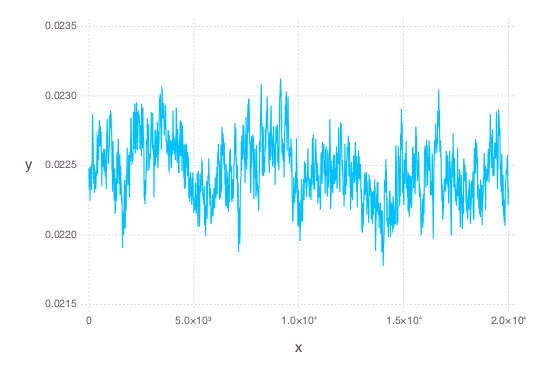

In [207]:
using Gadfly
plot(x = 1:10:nnmh, y = [mhθchain[k][1] for k in 1:10:nnmh], Geom.line)

### Anyway, store the chain with burn-in `100` and thin `5`. Call it `mhθresult`.

In [242]:
mhθsample = Vector{Float64}[]
for i in 100:5:nnmh
    push!(mhθsample, mhθchain[i])
end
mhθresult = zeros(Float64, length(mhθsample), 6)
for i in 1:length(mhθsample)
    mhθresult[i,:] = copy(mhθsample[i])
end

### Because the previous result is not good. We try a new proposal density which uses estimated covariance matrix of the previous result.

In [255]:
Σmh = cov(mhθresult)

6x6 Array{Float64,2}:
  4.75115e-8   -3.06806e-7   3.64278e-6   …   9.04354e-6    8.13295e-7 
 -3.06806e-7    3.91467e-6  -3.39431e-5      -6.10176e-5   -9.84384e-6 
  3.64278e-6   -3.39431e-5   0.000779839      0.00265895    9.35766e-5 
  5.37854e-10  -4.93842e-9   4.45808e-8       7.71213e-8    1.39116e-8 
  9.04354e-6   -6.10176e-5   0.00265895       0.0105784     0.000155651
  8.13295e-7   -9.84384e-6   9.35766e-5   …   0.000155651   2.91701e-5 

### Do Metropolis–Hastings again, but with the new proposal density.

In [289]:
nnmh_again = 30000
πθ = GaussianCMBPrior(mle_sim, eye(Float64, 6, 6) * 1e12);
postθcmb = CMBPosterior(πθ, bandpowers, b², σ²);
propθ_again = GaussianProposalDensity(0.2, Σmh);
mhθchain_again, α_again = mh(postθcmb, propθ_again, mle_sim, nnmh_again);

MH MCMC... 100% Time: 1:10:15


In [290]:
mean(exp(α_again))

0.5066262181284696

### It looks much better now.

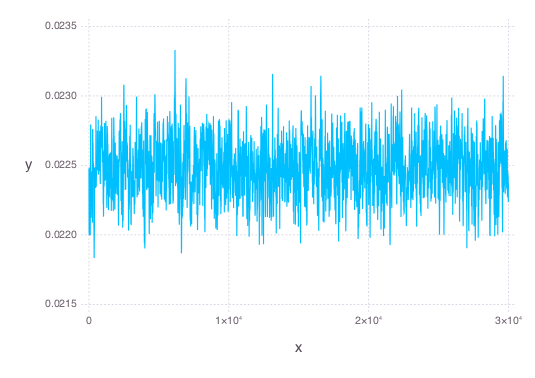

In [295]:
plot(x = 1:10:nnmh_again, y = [mhθchain_again[k][1] for k in 1:10:nnmh_again], Geom.line)

In [301]:
mhθsample_again = Vector{Float64}[]
for i in 100:5:nnmh_again
    push!(mhθsample_again, mhθchain_again[i])
end
mhθresult_again = zeros(Float64, length(mhθsample_again), 6)
for i in 1:length(mhθsample_again)
    mhθresult_again[i,:] = copy(mhθsample_again[i])
end

# Affine Invariant Markov chain Monte Carlo

Require package `ProgressMeter` for estimated time of arrival (because I want to know how long I will wait...)

In [120]:
function affine_invariant(post::PosteriorDensity, θwalkers::Vector{Vector{Float64}}, nitr::Int64, a::Float64)
    d = length(θwalkers[1])
    nwalkers = length(θwalkers)
    θchain = Array(Vector{Vector{Float64}}, nitr)
    for i in 1:nitr
        θchain[i] = Vector{Float64}[zeros(Float64, d) for k in 1:nwalkers]
    end
    
    θprop = zeros(Float64, d)
    
    θchain[1] = copy(θwalkers)
    @showprogress 2 "Affine Invariant... " for i in 1:nitr-1
        θchain[i+1][:] = deepcopy(θchain[i])
        zj = (rand(nwalkers) .* (√a - 1/√a) + 1/√a).^2
        selectj = rand(1:nwalkers-1, nwalkers)
        selectj[selectj .>= 1:nwalkers] += 1
        
        for j in 1:nwalkers
            θprop[:] = θchain[i][selectj[j]] + zj[j] * (θchain[i][j] - θchain[i][selectj[j]])
            logα = min((d-1) * log(zj[j]) + post(θprop) - post(θchain[i][j]), 0)
            if log(rand()) <= logα
                θchain[i+1][j] = copy(θprop)
            end
        end
    end
    
    return θchain
end


affine_invariant (generic function with 2 methods)

### The initial ensemble of walkers

The initial ensemble of walkers is generated as **independent** gaussian random variables in each coordinate (with **variance a little bigger** than estimated varaince from the WMAP MCMC sample).

The reason I do this is that, from the first Metropolis–Hastings sample above, I know that the WMAP covariance matrix is not a good approximation. Therefore I want to try an ensemble of walkers with wider cover on the parameter space. 

The number of walkers is 50.

In [214]:
θwalkers = Vector{Float64}[mle_sim + diagm( 2 * sqrt(diag(Σwmap))) * randn(6) for k in 1:50];

### Number of iteration is `nnai = 500`

In [216]:
nnai = 500
@time aiθchain = affine_invariant(postθcmb, θwalkers, nnai, 2.0);

Affine Invariant... 100% Time: 1:04:34
3873.639200 seconds (90.59 M allocations: 47.490 GB, 0.35% gc time)


### Plot of the walkers

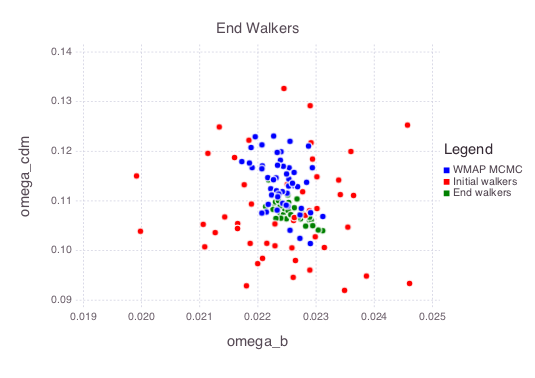

In [297]:
plot(
layer(x = omega_b_chain[1:length(θwalkers)], 
y = omega_cdm_chain[1:length(θwalkers)], 
Geom.point, 
Theme(default_color = colorant"blue")),
layer(x = Float64[θwalkers[k][1] for k in 1:length(θwalkers)], 
y = Float64[θwalkers[k][2] for k in 1:length(θwalkers)], 
Geom.point, 
Theme(default_color = colorant"red")),
layer(x = Float64[aiθchain[nnai][k][1] for k in 1:length(θwalkers)], 
y = Float64[aiθchain[nnai][k][2] for k in 1:length(θwalkers)], 
Geom.point, 
Theme(default_color = colorant"green")),
Guide.xlabel("omega_b"),  Guide.ylabel("omega_cdm"),
Guide.title("End Walkers"),
Guide.manual_color_key("Legend", ["WMAP MCMC", "Initial walkers", "End walkers"], ["blue", "red", "green"])
)

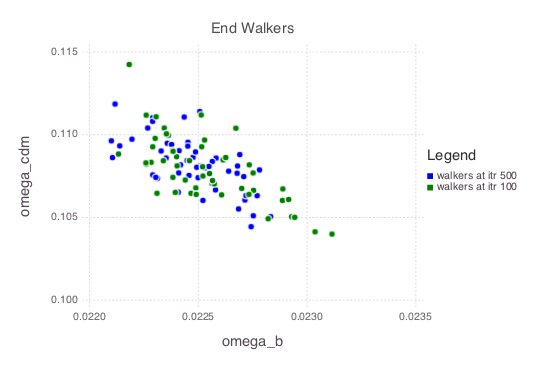

In [298]:
plot(
layer(x = Float64[aiθchain[nnai][k][1] for k in 1:length(θwalkers)], 
y = Float64[aiθchain[nnai][k][2] for k in 1:length(θwalkers)], 
Geom.point, 
Theme(default_color = colorant"green")),
layer(x = Float64[aiθchain[100][k][1] for k in 1:length(θwalkers)], 
y = Float64[aiθchain[100][k][2] for k in 1:length(θwalkers)], 
Geom.point, 
Theme(default_color = colorant"blue")),
Guide.xlabel("omega_b"),  Guide.ylabel("omega_cdm"),
Guide.title("End Walkers"),
Guide.manual_color_key("Legend", ["walkers at itr 500", "walkers at itr 100"], ["blue", "green"])
)

### Our MCMC sample is the walkers at iteration `50:5:nnai`

In [317]:
aiθsample = Vector{Float64}[]
for i in 50:5:nnai
    append!(aiθsample, aiθchain[i])
end
ai_result = zeros(Float64, length(aiθsample), 6)
for i in 1:length(aiθsample)
    ai_result[i,:] = copy(aiθsample[i])
end

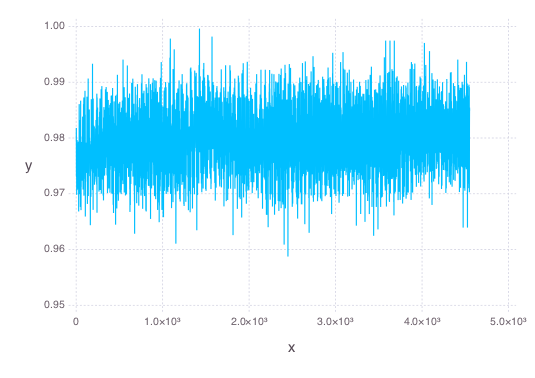

In [318]:
plot(x = 1:length(aiθsample), y = [aiθsample[k][6] for k in 1:length(aiθsample) ], Geom.line)

# Plot of Metropolis–Hastings algorithm and Affine Invariant MCMC

### Metropolis–Hastings

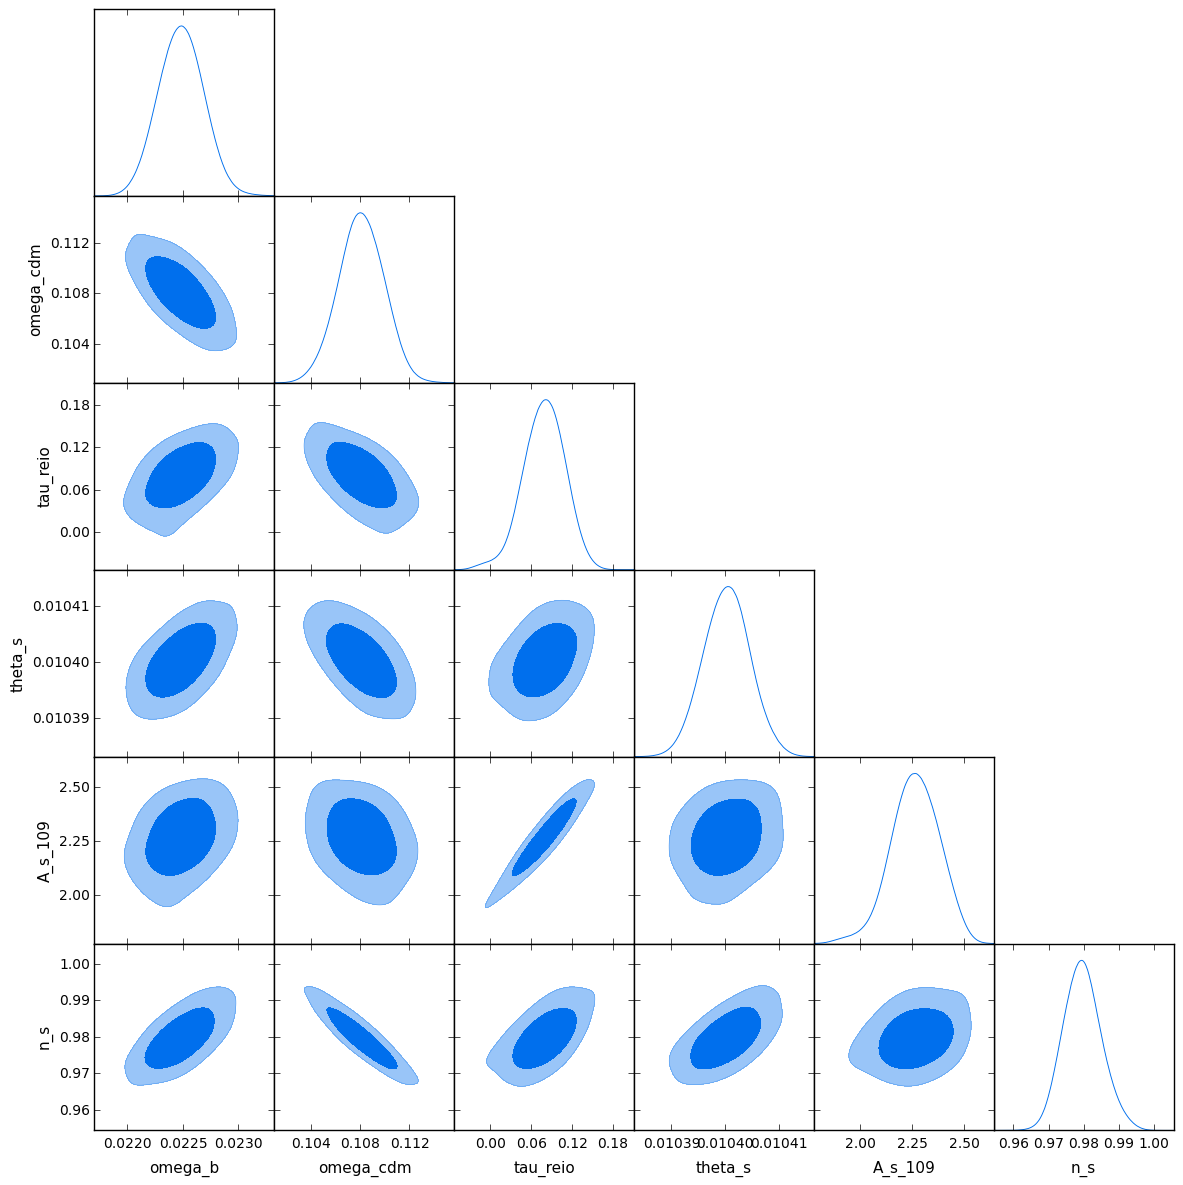

In [325]:
using PyCall, PyPlot

@pyimport getdist
@pyimport getdist.plots as plots
samples = getdist.MCSamples(samples=mhθresult_again, names=names_chain)
g = plots.getSubplotPlotter()
g[:triangle_plot](samples, filled=true, legend_labels = ["MH"])

### Affine Invariant MCMC

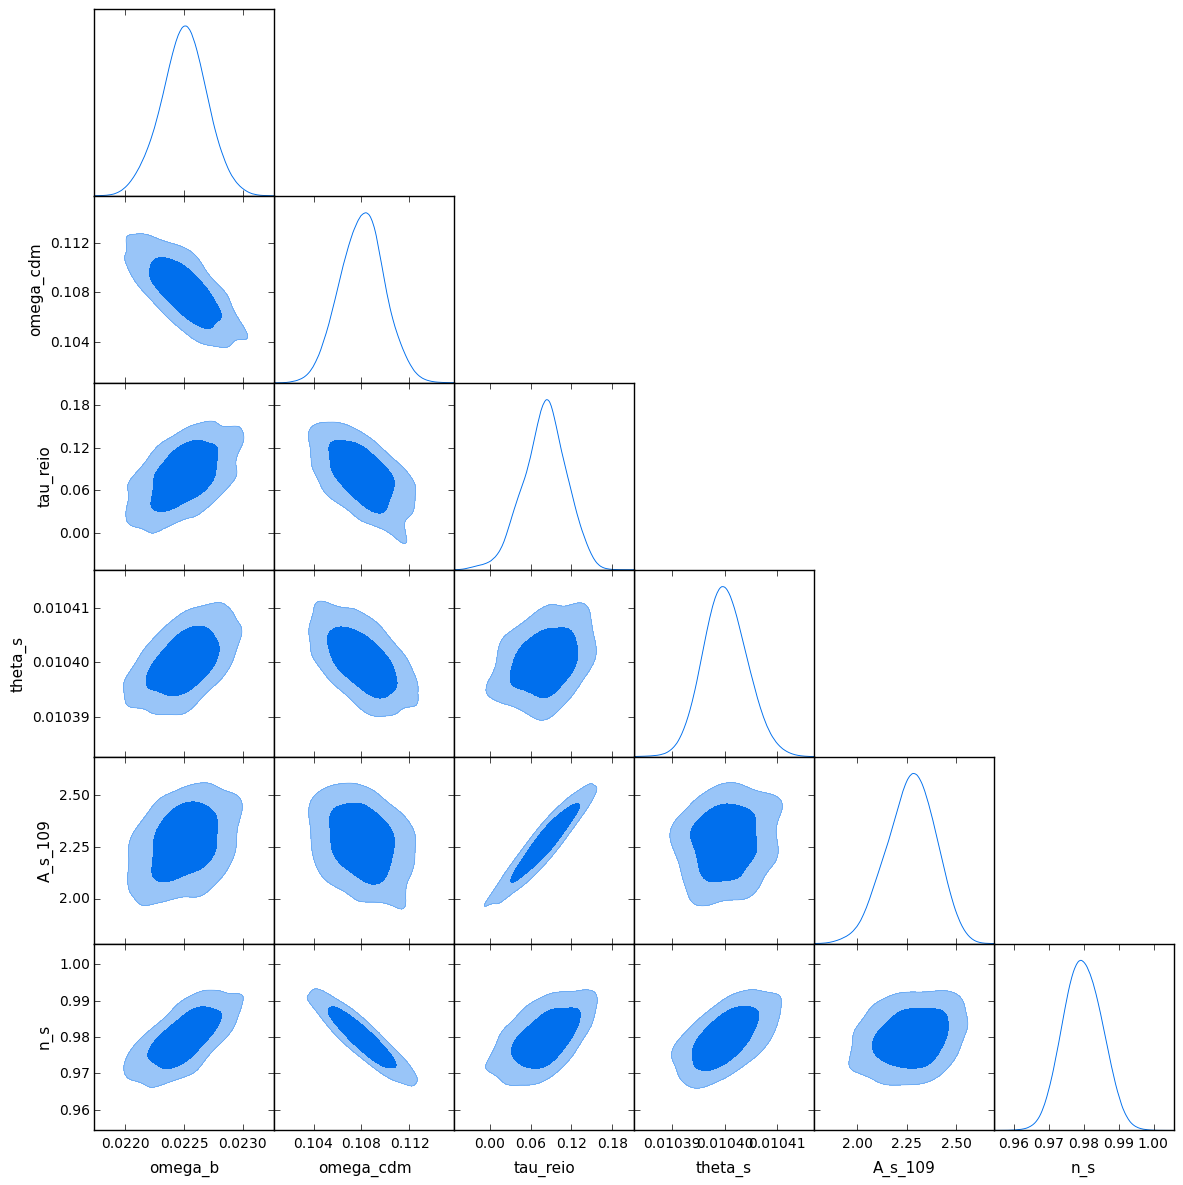

In [326]:
samples = getdist.MCSamples(samples=ai_result, names=names_chain)
g = plots.getSubplotPlotter()
g[:triangle_plot](samples, filled=true, legend_labels = ["AI"])

### Metropolis–Hastings algorithm and Affine Invariant MCMC

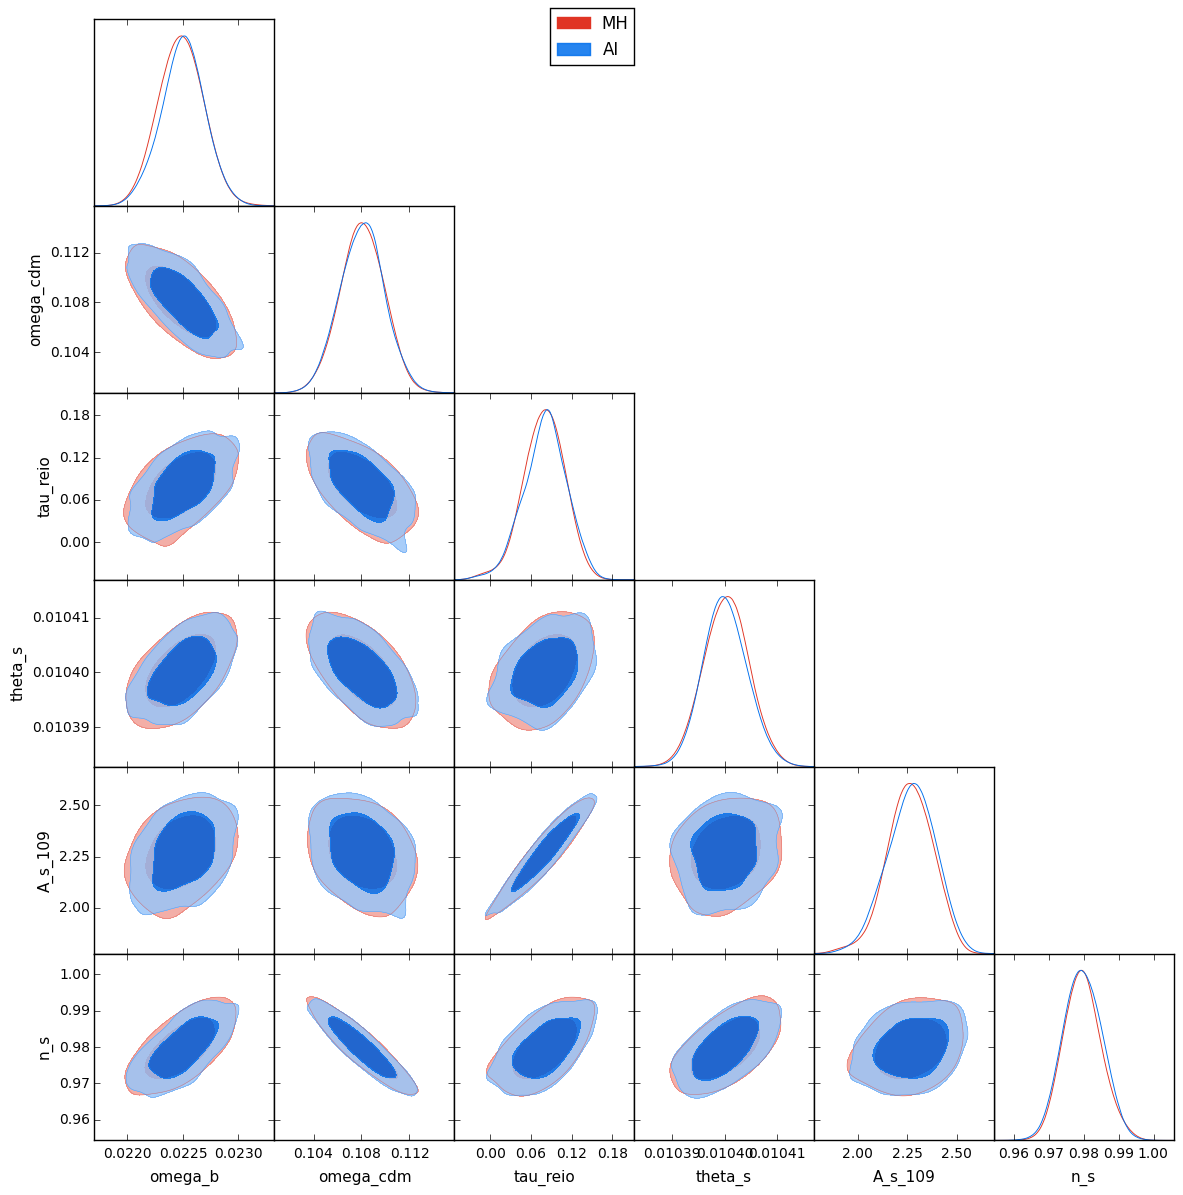

In [322]:
samples1 = getdist.MCSamples(samples=mhθresult_again, names=names_chain)
samples2 = getdist.MCSamples(samples=ai_result, names=names_chain)
g = plots.getSubplotPlotter()
g[:triangle_plot]([samples1, samples2], filled=true, legend_labels = ["MH", "AI"])

### Compare to WMAP MCMC

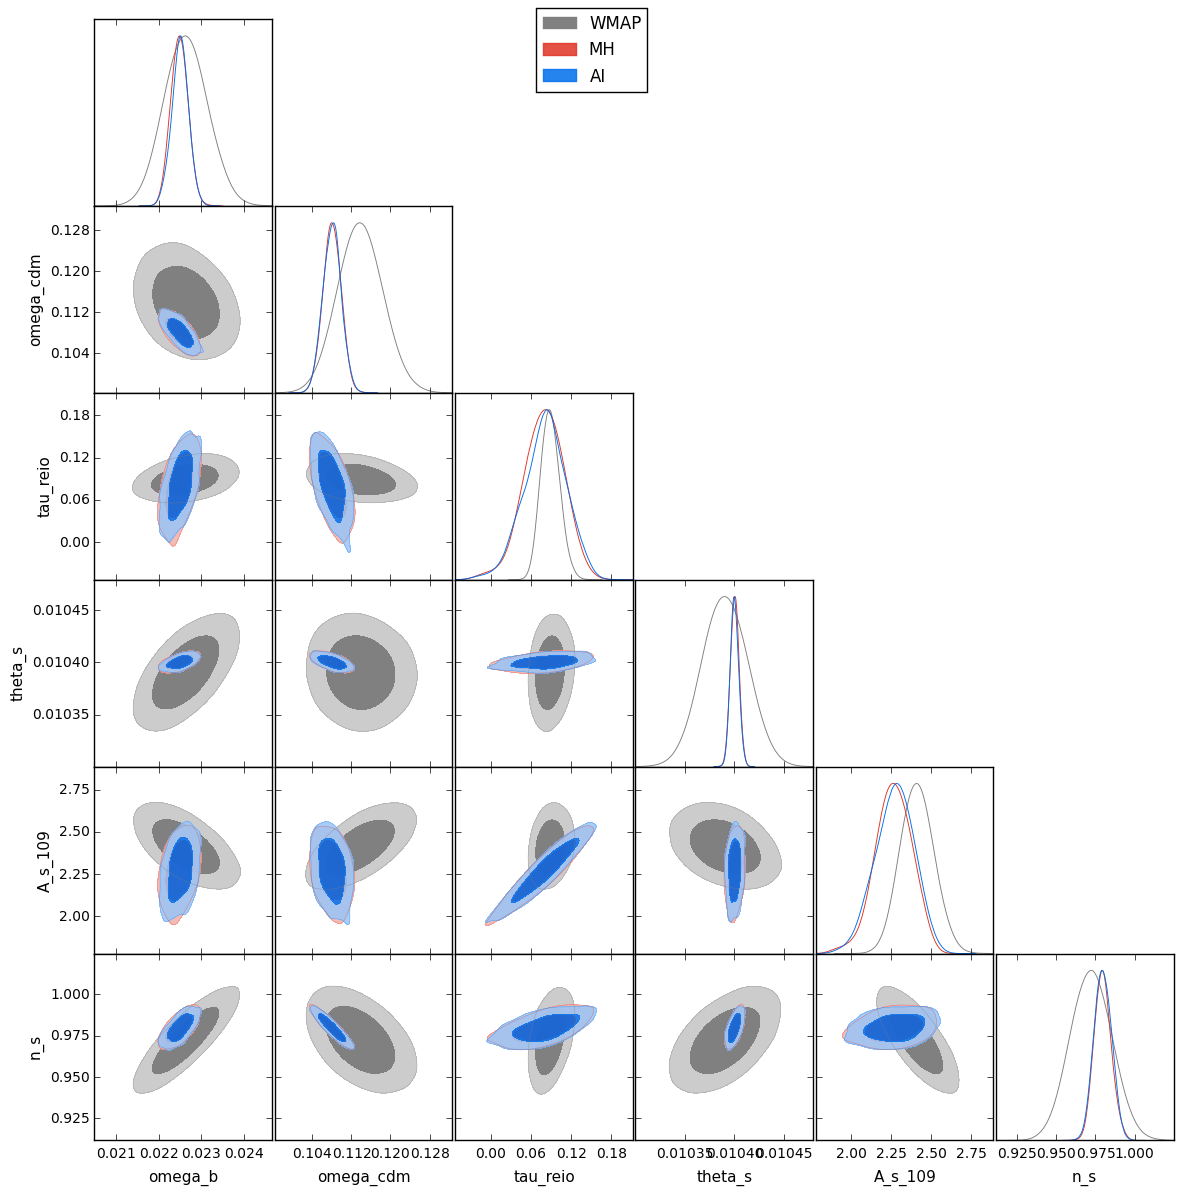

In [323]:
samples0 = getdist.MCSamples(samples=full_chain, names=names_chain)
samples1 = getdist.MCSamples(samples=mhθresult_again, names=names_chain)
samples2 = getdist.MCSamples(samples=ai_result, names=names_chain)
g = plots.getSubplotPlotter()
g[:triangle_plot]([samples0, samples1, samples2], filled=true, legend_labels = ["WMAP", "MH", "AI"])